In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import math
from ultralytics import YOLO
import itertools

# import tensorflow as tf
from tensorflow.keras.models import load_model

# Load image

In [2]:
def resize(frame, width = 640, height = 640):
    return cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)

def preprocess_image(frame):
    return resize(frame)

def load_image(path):
    return cv.imread(path)

# Feature Extraction

In [3]:
def MaskStrength(mask, img):
    """
    Calculates Pixel Strength for mask
    1. Apply mask on the original color image
    2. Calculate average of non zero pixels
    """
    mask_3d = np.expand_dims(mask, axis=-1)
    masked_array = (img * mask_3d).flatten()
    return masked_array[masked_array>0].mean().round(2)

def MaskCentroid(mask):
    """
    Calculates Centroid for mask
    1. Extract indices of non zero pixels in a mask
    2. Calculate average of x and y coordinates
    3. Flip the array, since here x and y corresponds to row and column
    """
    mask_indices = np.where(mask)
    mask_centroid = np.round(np.mean(mask_indices, axis=1))
    flip_centroid = list(np.flip(mask_centroid))
    return flip_centroid

In [4]:
def extract_features_inferencing(results, feature_list):
# Check if atleast one mask exist
    frame = 0
    result = results[0]
    features = {key: [] for key in feature_list}
    d = {key: [] for key in ['n_masks', 'width', 'height', 'bbox_centroid', 'box_area', 'mask_area', 'mask_centroid', 'mask_strength']}
    if result.masks is not None:

        # Calculate number of masks in the segmented image
        features['n_masks'] = len(result.masks)    

        # Bounding Box Parameters
        bboxes = result.boxes

        bbox_data = np.array(bboxes.data)
        width = []
        height = []
        x_centroid = []
        y_centroid = []
        box_area = []
        for box in bbox_data:
            # Extract Bounding box dimension [Width, Height] for each box
            w = np.round(abs(box[0] - box[2]))
            h = np.round(abs(box[1] - box[3]))
            d['width'].append(w)
            d['height'].append(h)            

            # Extract Bounding box Centroid for each box
            xcoord = np.round(np.mean([box[0], box[2]]))
            ycoord = np.round(np.mean([box[1], box[3]]))
            d['bbox_centroid'].append([xcoord, ycoord])

            # Calculate Bounding box Area for each box
            d['box_area'].append(w*h)
        
        features['bbox_width'] = np.mean(d['width'])
        features['bbox_height'] = np.mean(d['height'])
        features['bbox_area'] = np.mean(d['box_area'])
        features['bbox_centroid_dist'] = calc_pair_distance(d['bbox_centroid'])
        
        # Mask Parameters
        masks = np.array(result.masks.data, dtype='uint8')
        mask_area = []
        
        for mask in masks:
            # Mask Area: Count number of non zero pixels in mask
            d['mask_area'].append(np.count_nonzero(mask))

            # Mask Centroid: Calculate mean of non zero pixel x and y coordinates
            d['mask_centroid'].append(MaskCentroid(mask))

            ## Mask Strength: 
            # Apply mask on the original image
            # Measure average pixel strength excluding non zero pixels
            d['mask_strength'].append(MaskStrength(mask, result.orig_img))        
        
        features['mask_area'] = np.mean(d['mask_area'])
        features['mask_strength'] = np.mean(d['mask_strength'])
        features['mask_centroid_dist'] = calc_pair_distance(d['mask_centroid'])
        
        return [features[key] for key in features.keys()]
    else:        
        return [0 for key in features.keys()]

In [5]:
def calc_dim(val, ind):
    val = np.array(val)
    if val.ndim == 1 and len(val) > 1: #Single Box
        return val[ind]
    elif val.ndim > 1: # More than 1 Box
        if len(val[:,0]) == 0:
            return -1
        return np.mean(val[:,0])
    else: # 0 Box
        return 0   
    
def calc_pair_distance(val):
    pair_distances = [np.linalg.norm(np.array(p1) - np.array(p2)) for p1, p2 in itertools.combinations(val, 2)]
    if len(pair_distances) != 0:    
        return np.round(sum(pair_distances) / len(pair_distances),2)
    else:
        return 0

# Visibility Estimation

In [6]:
class visibility_estimation():
    def __init__(self):
        self.gaussian_kernel = 3
        self.multiplier = 5
        self.ref_edges = -1
        
    def reference_visibility(self, ref_image_path):
        reference_image = load_image(ref_image_path)
        ref_preprocessed = preprocess_image(reference_image)
        self.ref_edges = self.count_edges(ref_preprocessed)
                
    def edge_detection(self, img):    
        gradx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
        grady = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
        return gradx, grady

    def preprocess(self, img):
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_blur = cv.GaussianBlur(img, (self.gaussian_kernel, self.gaussian_kernel), 0)
        gradx, grady = self.edge_detection(img_blur)
        grad_mag = cv.magnitude(gradx, grady)
        grad_mag_norm = cv.normalize(grad_mag, None, 0, 255, cv.NORM_MINMAX)
        return grad_mag_norm

    def count_edges(self, target_img):
        preprocessed_img = self.preprocess(target_img)
        _, thresh = cv.threshold(preprocessed_img, self.multiplier * np.median(preprocessed_img), 255, cv.THRESH_BINARY)             
        total_edges = np.count_nonzero(thresh)
        return total_edges

    def edge_strength_ratio(self, preprocessed_img):
        if self.ref_edges > 0:
            target_edge = self.count_edges(preprocessed_img)
            print(target_edge, self.ref_edges)
            return np.round((target_edge / self.ref_edges),2)
        else:
            print("Estimate Reference Visibility")
            return -1

# Hydrogen Spark Detection

In [7]:
class spark_detection():
    def __init__(self):
        self.yolo_model_path = r"Models\yolo_model.pt"
        self.lstm_model_path = r"Models\lstm_model.h5"
        self.feature_list = ['n_masks', 'mask_area', 'bbox_area','mask_strength','bbox_width', 'bbox_height', 'mask_centroid_dist', 'bbox_centroid_dist']
        self.lstm_input = np.zeros((10, len(self.feature_list)))
        
        
    def load_models(self):
        try:
            print
            self.yolo_model = YOLO(self.yolo_model_path)                       
        except:
            print("Error Loading YOLO Model")
            
        try:
            self.lstm_model = load_model(self.lstm_model_path)                      
        except:
            print("Error Loading LSTM Model")

    def update_window(self, new):
        self.lstm_input[:-1] = self.lstm_input[1:]
        self.lstm_input[-1] = new

    def inference_image(self, img_path):
        raw_image = load_image(img_path)
    
        # Preprocess Image
        processed_image = preprocess_image(raw_image)

        # YOLO Inferencing
        results = self.yolo_model(processed_image, conf=0.2, iou=0.5, save=True, show_labels=False, retina_masks=True)

        # Feature Extraction
        extracted_features = extract_features_inferencing(results, self.feature_list)    

        # Prepare Data
        self.update_window(extracted_features)

        # LSTM Inferencing
        final_result = self.lstm_model.predict(self.lstm_input[np.newaxis, :])[0][0]
        
        return results, final_result
        

# Test

In [18]:
ref_image = r"F:\Work\SOCAAutomation\Dataset\Images\Reference_Images\04_07_2024\1.jpg"
test_folder = r"F:\Work\SOCAAutomation\Dataset\Images\Fullset_reduced\04_07_2024\2024-07-04_11_51_08_772\4"
res = []
det_obj = spark_detection()
det_obj.load_models()


Loading Image: 69.jpg

0: 640x640 9 Fires, 9437.8ms
Speed: 268.3ms preprocess, 9437.8ms inference, 1524.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict41
1/1 [==============================] - 45s 45s/step
Image Inferenced...



In [29]:
for ind, file in enumerate(os.listdir(test_folder)):
    if ind < 1:
        continue
    # Load Image
    print(f"Loading Image: {file}")
    yolo_res, lstm_res = det_obj.inference_image(test_folder + "/" + file)   

    print("Image Inferenced...")
    print("")
    break

Loading Image: 66.jpg

0: 640x640 1 Fire, 4420.3ms
Speed: 22.8ms preprocess, 4420.3ms inference, 40.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict41
1/1 [==============================] - 23s 23s/step
Image Inferenced...



True


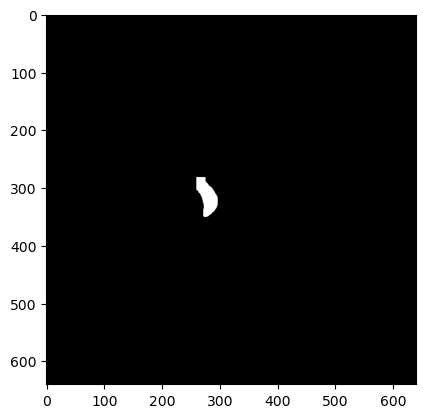

In [34]:
test_img_resized = preprocess_image(cv.imread(test_folder + "/" + file))
if yolo_res[0].masks is not None:
    masks = np.array(yolo_res[0].masks.data)
    combined_mask = np.any(masks, axis=0).astype(np.uint8)
    combined_mask_3ch = cv.merge([combined_mask * 255]*3)
    print("True")
else:
    combined_mask_3ch = np.zeros((640, 640, 3), dtype=np.uint8)
masked_img = cv.bitwise_and(test_img_resized, test_img_resized, mask=combined_mask)
plt.imshow(combined_mask_3ch)